In [76]:
import json
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import statistics
import cv2
from PIL import Image
import scipy.signal as signal
import time
from joblib import Parallel, delayed

In [2]:
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    #return imageio.imread(f'./data/sequences/{group}-{student}.tif')
    return imageio.imread(f'../../{group}-{student}.nosync.tif')

In [3]:
#data = load_json(1,1)
images = load_images(9,3)

In [91]:
background = np.zeros((10,images.shape[1],images.shape[2]))
images_mean = np.mean(images,axis=3)
background[0] = np.mean(images_mean[:1],axis=(0))

for i in range(1,10):
    background[i] = np.mean(images_mean[:10*i],axis=(0))


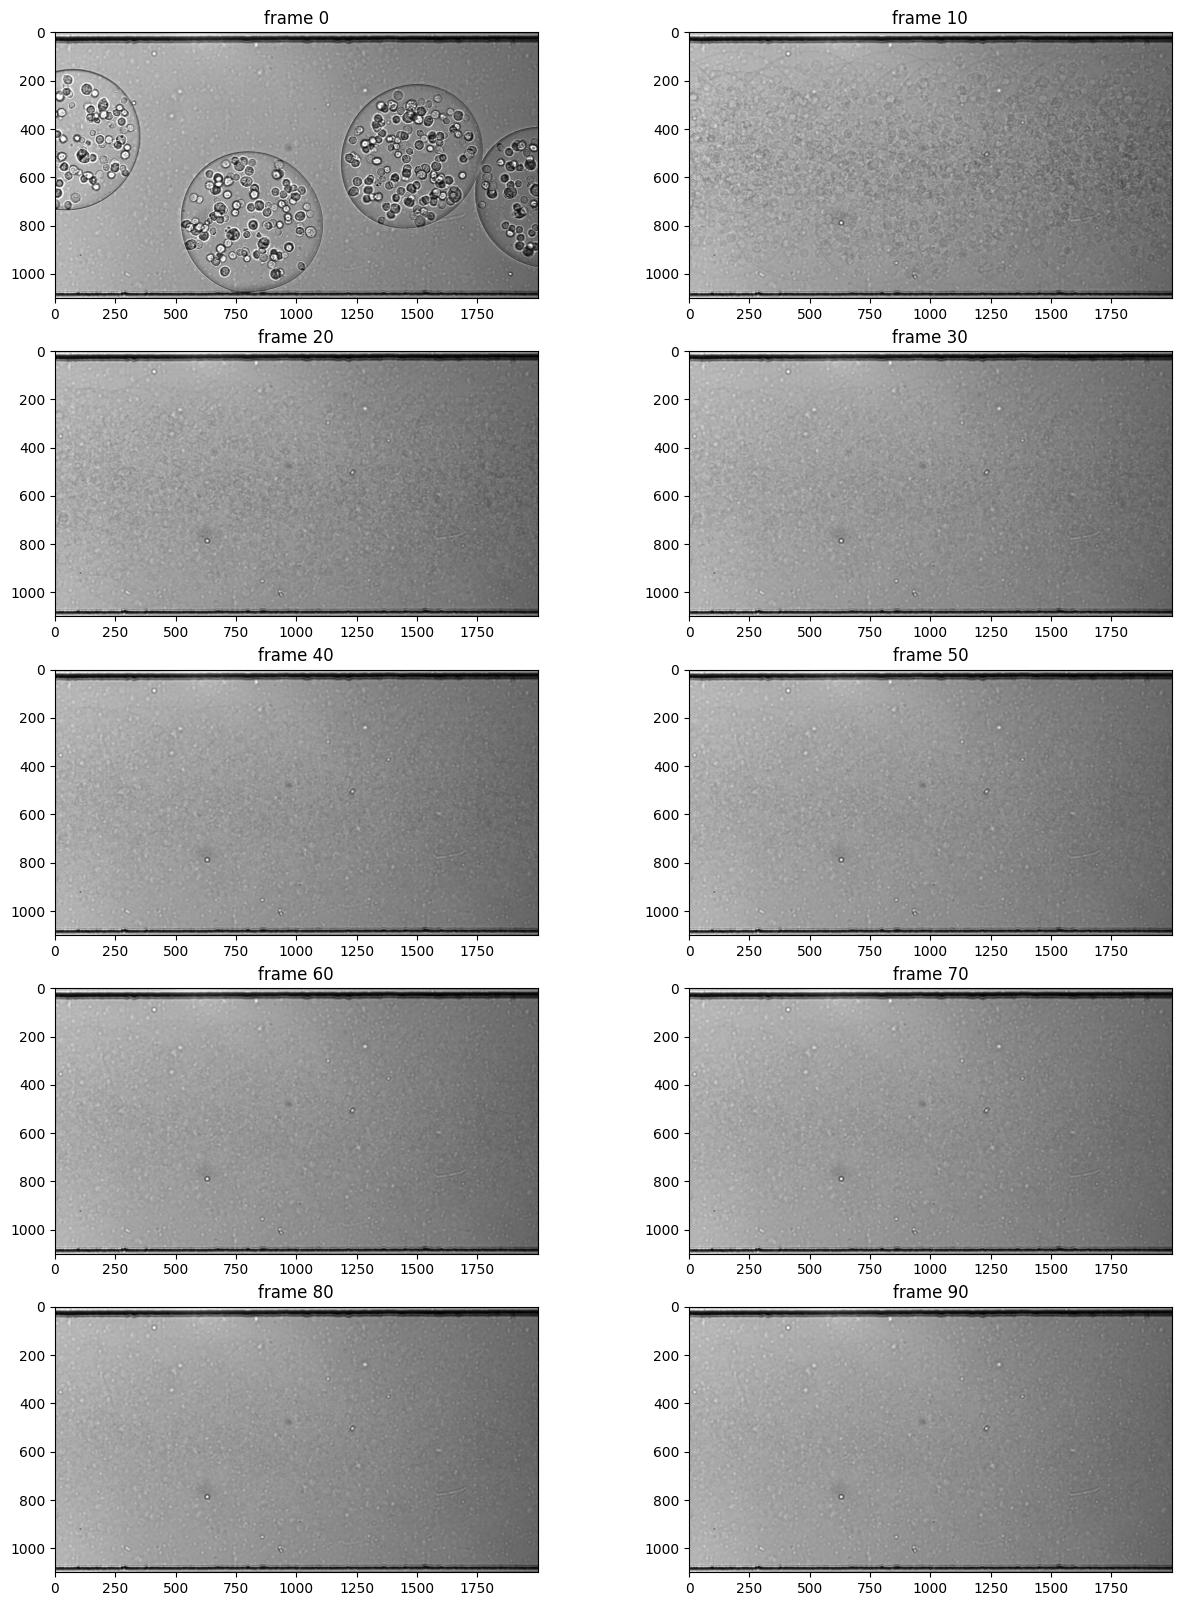

In [5]:
fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(background[i], cmap='gray')
    axs[i//2,i%2].set_title(f'frame {i*10}')
plt.show()

--- Execution time = 2.5210509300231934 seconds ---
--- Frame rate 0.025210509300231932 seconds/frame ---
--- Frame rate 39.66599754455576 frame/seconds ---


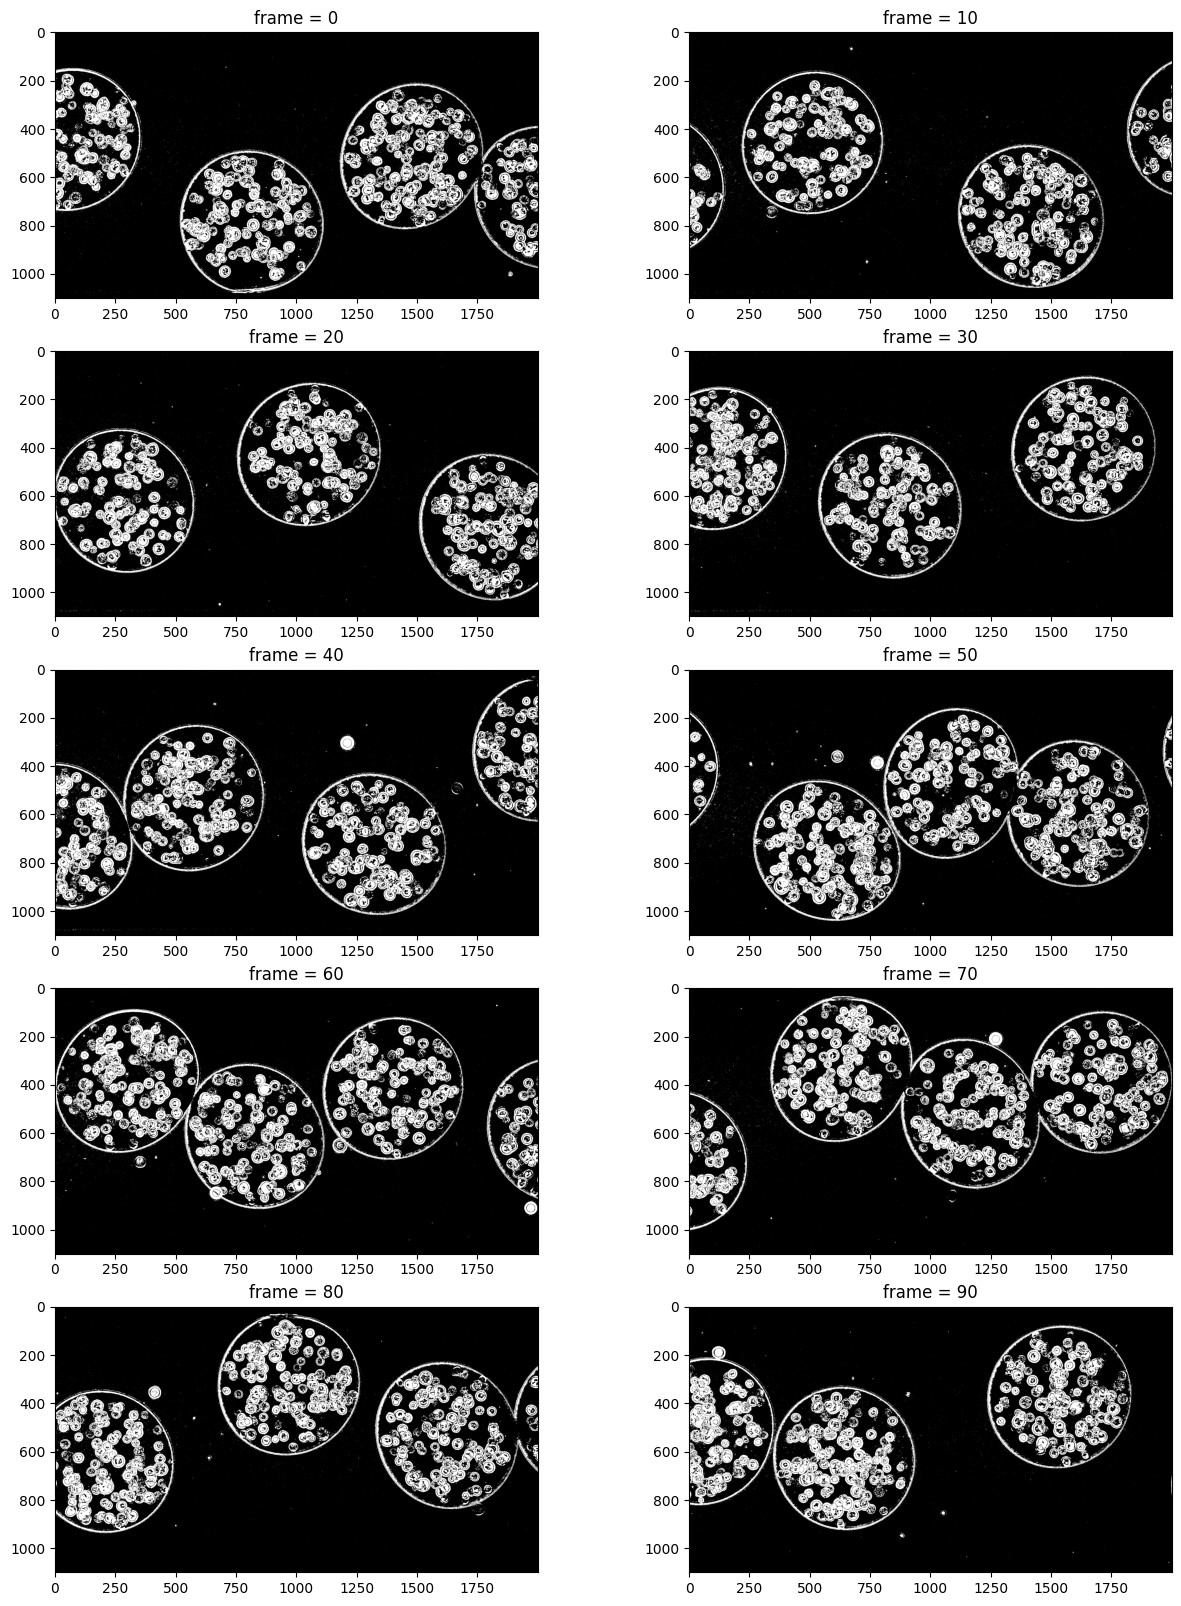

In [106]:
# Naive method BRODCAST
nb_sample = 100
threshold = 30
back = background[9]

start_time = time.time()
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))
back = np.broadcast_to(back, (nb_sample, images.shape[1],images.shape[2]))
masks[threshold < abs(images_mean - back)] = 1
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
    axs[i//2,i%2].set_title(f'frame = {10*i}')

--- Execution time = 2.063743829727173 seconds ---
--- Frame rate 0.02063743829727173 seconds/frame ---
--- Frame rate 48.45562640069529 frame/seconds ---


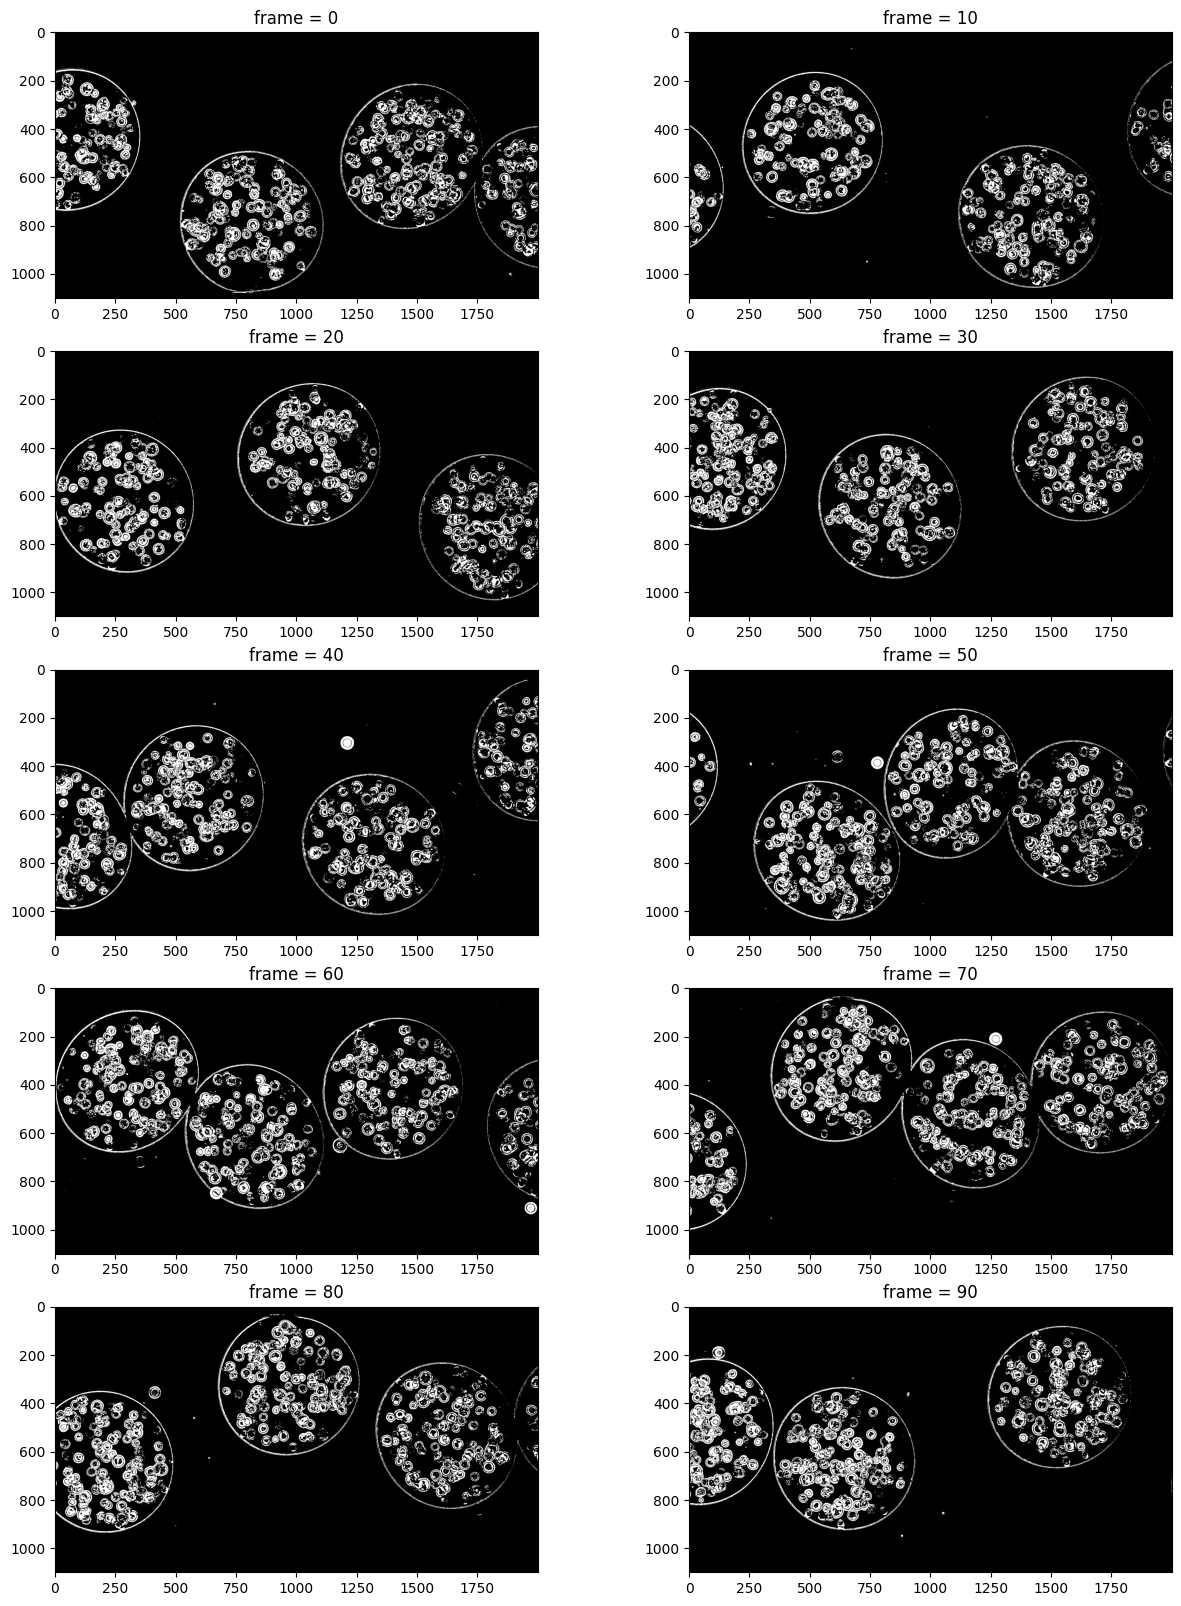

In [112]:
# Naive method Loop
nb_sample = 100
threshold = 0.2
back = background[9]
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))

start_time = time.time()
for i in range(nb_sample):
    im = images_mean[i]
    masks[i] =  (abs(im - back) / np.max(im)) > threshold
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
    axs[i//2,i%2].set_title(f'frame = {10*i}')

--- Execution time = 1.546226978302002 seconds ---
--- Frame rate 0.01546226978302002 seconds/frame ---
--- Frame rate 64.67355789498355 frame/seconds ---


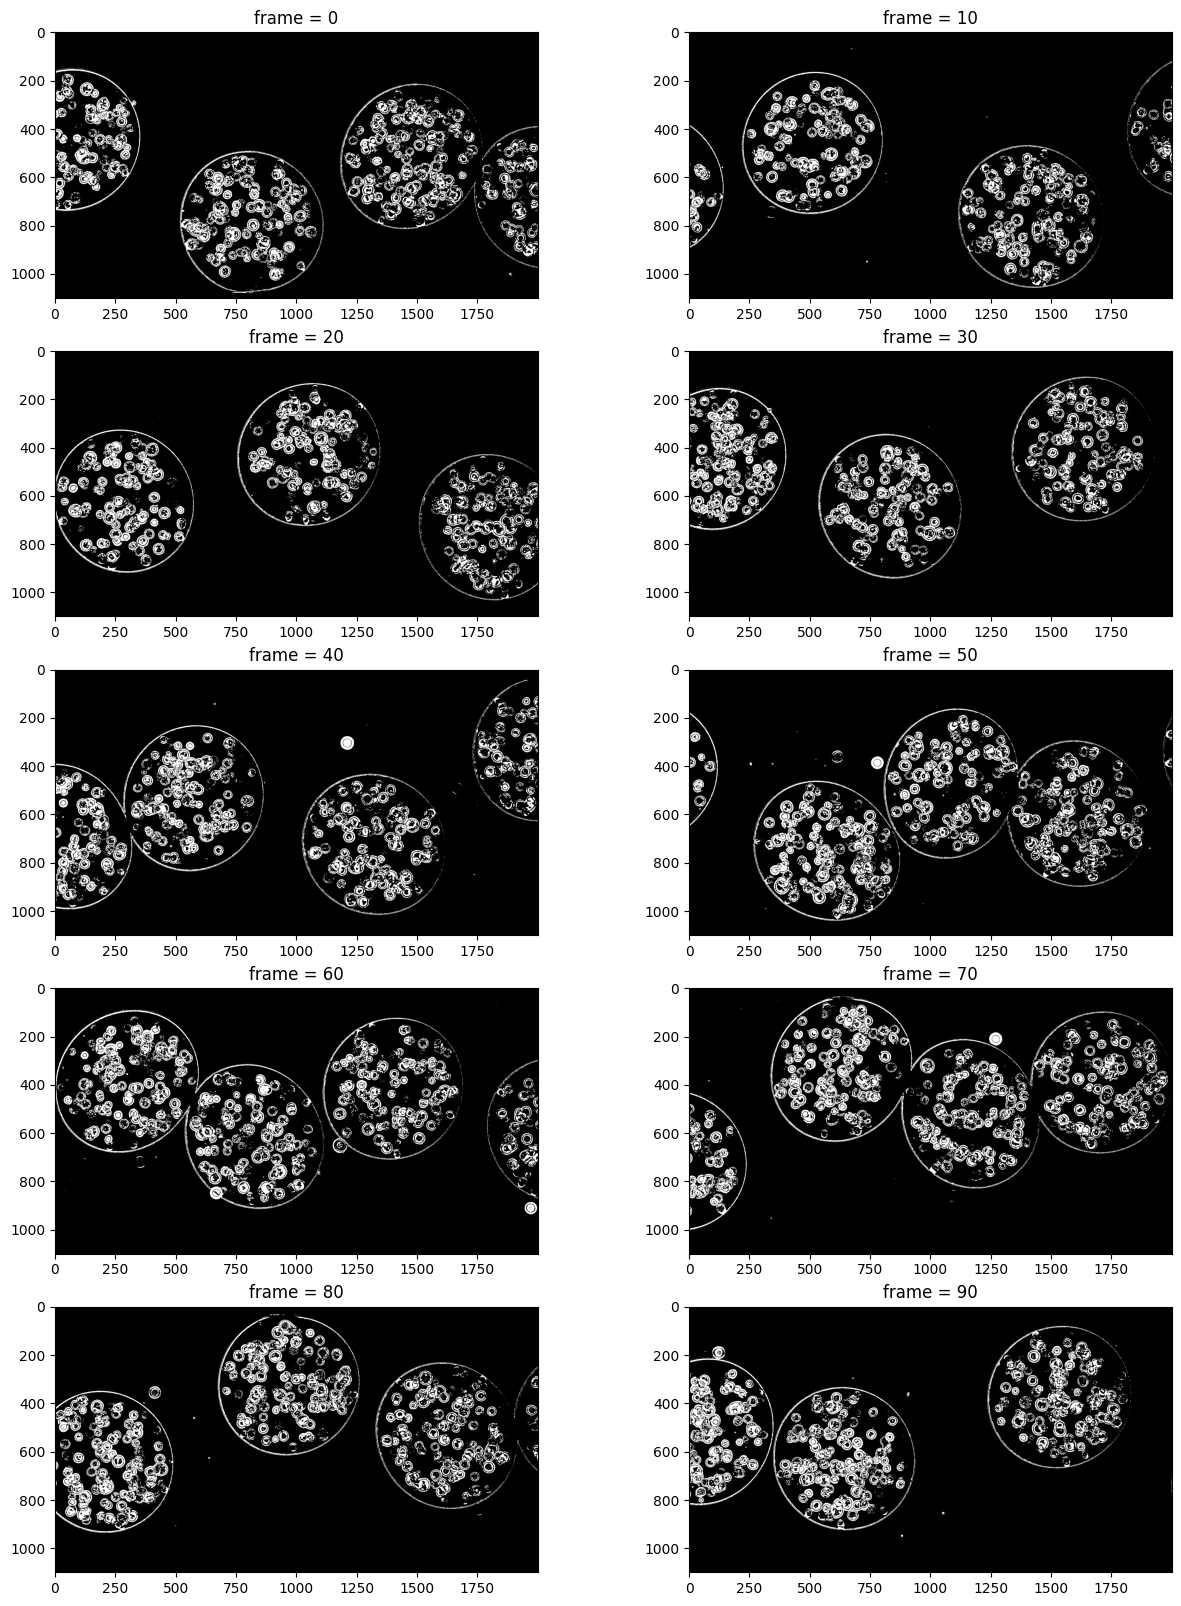

In [135]:
# Naive method Loop
nb_sample = 100
threshold = 0.2
back = background[9]
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))


def process(i,images_mean,back):
    im = images_mean[i]
    masks[i] =  (abs(im - back) / np.max(im)) > threshold
    return masks[i]

start_time = time.time()  
results = Parallel(n_jobs=-1, prefer="threads")(delayed(process)(i,images_mean,back) for i in range(nb_sample))
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
    axs[i//2,i%2].set_title(f'frame = {10*i}')

In [73]:
# Vibe algorithm

def vibe(image, nb_sample, min_match, threshold, samples, learning = True, learning_rate = 0.1, neighboor = True):
    
    result = np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
    inter = np.zeros((image.shape[0],image.shape[1],nb_sample),dtype=np.uint8)
    #samples = np.zeros((image.shape[0],image.shape[1],nb_sample),dtype=np.uint8)
    distances = np.tile(image[:, :, np.newaxis], nb_sample)
    distances = np.abs(distances - samples)
    inter[distances < threshold] = 1
    result = np.sum(inter,axis=2)
    mask = result < min_match
    if learning:
        rand = np.random.rand(image.shape[0],image.shape[1])
        place = np.random.randint(0,nb_sample,(image.shape[0],image.shape[1]))
        # update background at location
        update = rand < learning_rate
        samples[update,place[update]] = image[update]
        # updeate background in neighborhood
        if neighboor:
            rand = np.random.rand(image.shape[0],image.shape[1])
            r1 = np.random.randint(-1,2)
            r2 = np.random.randint(-1,2)
            place_neighboor = np.random.randint(0,nb_sample,(image.shape[0],image.shape[1]))
            update_neighborhood = rand < learning_rate
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    if update_neighborhood[i,j]:
                        r1 = np.random.randint(-1,2)
                        if i+r1 < 0 or i+r1 >= image.shape[0]:
                            r1 = 0
                        r2 = np.random.randint(-1,2)
                        if j+r2 < 0 or j+r2 >= image.shape[1]:
                            r2 = 0
                        samples[i+r1,j+r2,place_neighboor[i,j]] = image[i,j]

    return mask,samples


0
5.98833703994751
10
4.617751966823231
20
4.513536623546055
30
4.485804319381714
40
4.479941885645797
50
4.468136460173364
60
4.465489512584249
70
4.458493951340796
80
4.455071802492495
90
4.454335438026177


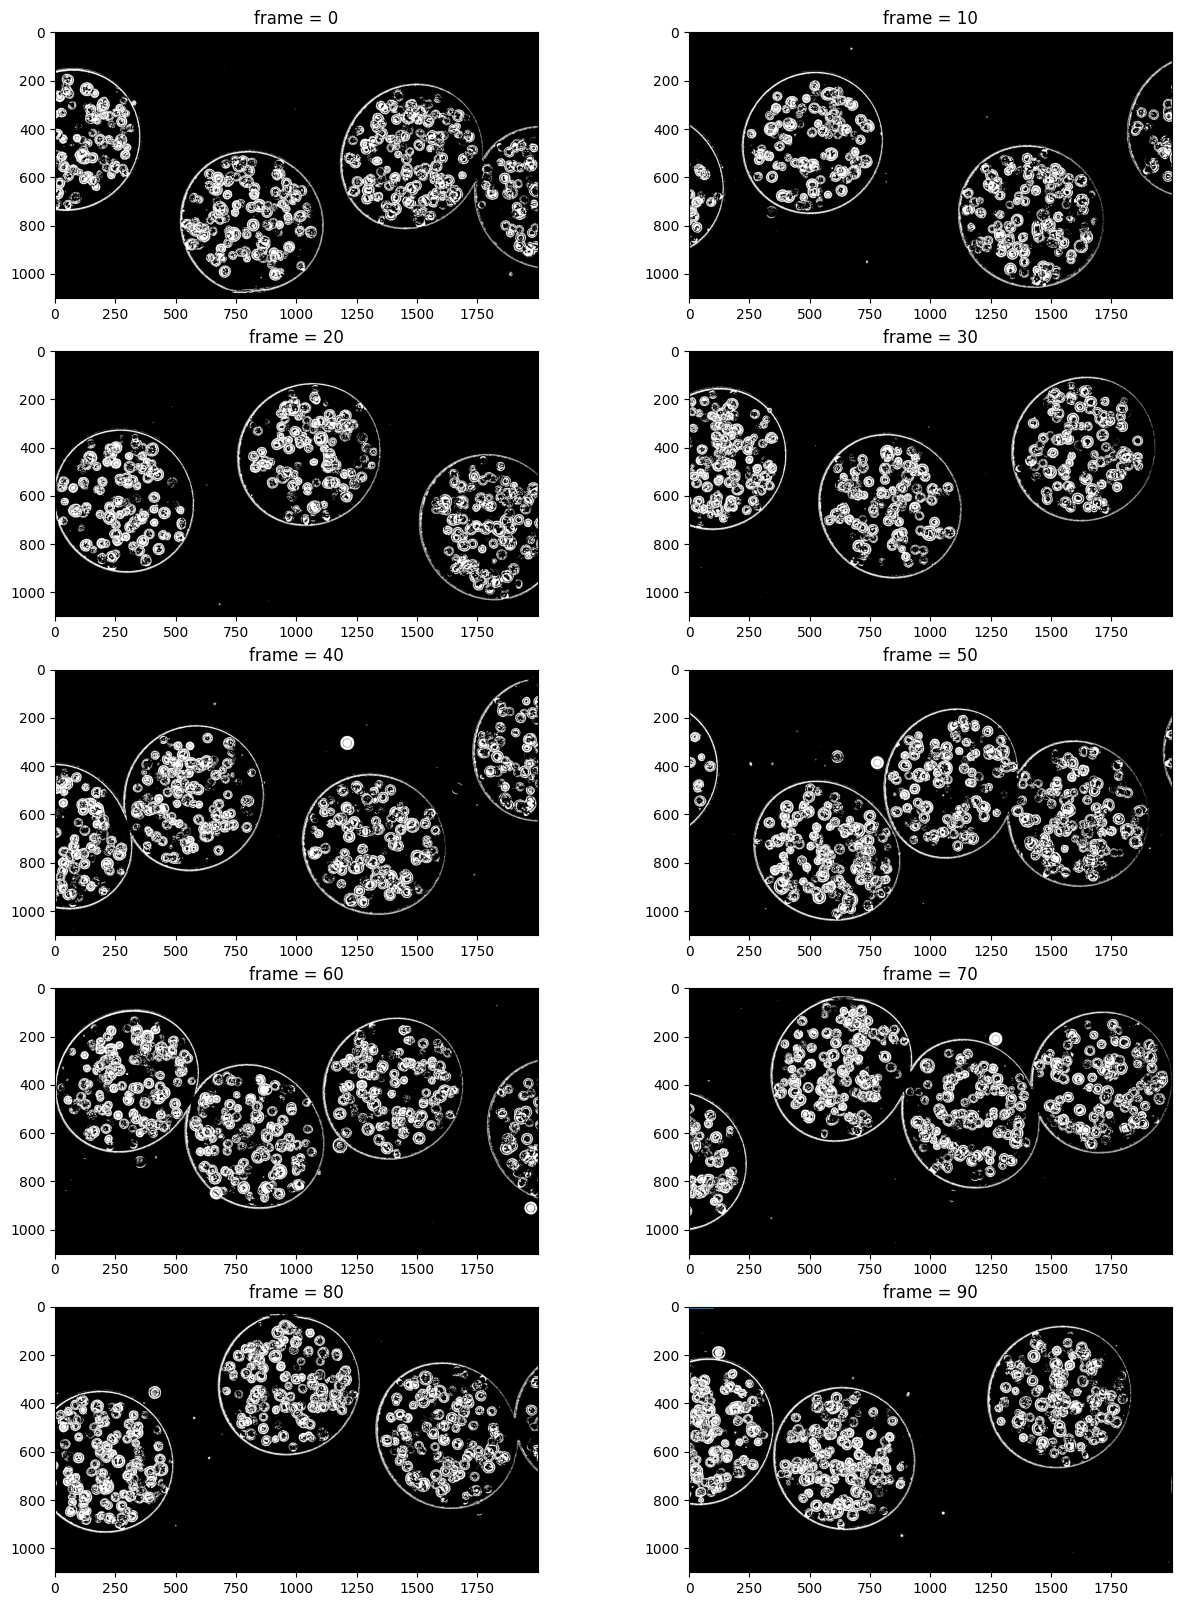

In [79]:
nb_sample = 100
mask = np.zeros((nb_sample,images.shape[1],images.shape[2]),dtype=np.uint8)
back = background[9]
samples = np.tile(back[:, :, np.newaxis], nb_sample)
exec_time = np.zeros(100)
for i in range(nb_sample):
    start_time = time.time()
    mask[i], samples = vibe(images_mean[i], nb_sample, 2, 40, samples, learning = False)
    exec_time[i] = time.time() - start_time
    if i%10 == 0:
        print(i)
        print(statistics.mean(exec_time[:i+1]))

fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(mask[i*10], cmap='gray')
    axs[i//2,i%2].set_title(f'frame = {10*i}')
plt.plot(exec_time)

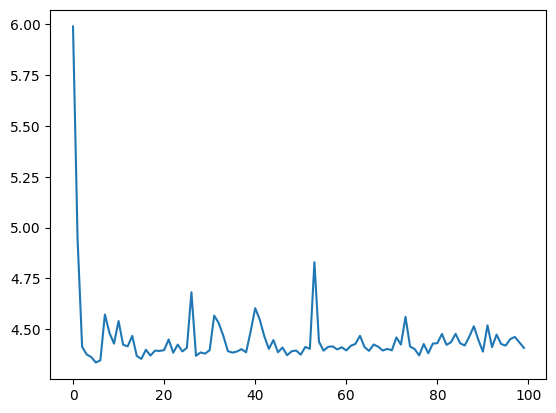

In [80]:
plt.plot(exec_time)

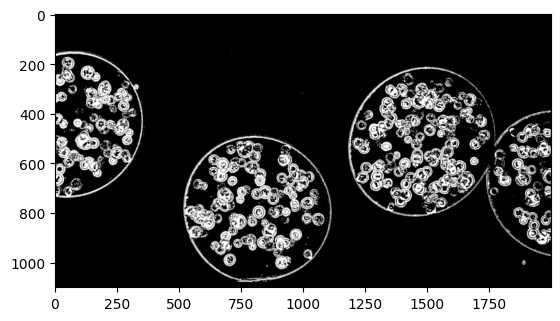

In [42]:
im_raw = mask
im_clean = np.zeros(im_raw.shape)
conv = np.array([[0,1,0],[1,0,1],[0,1,0]])
im_conv = signal.convolve2d(im_raw, conv, boundary='symm', mode='same')
im_conv = signal.convolve2d(im_conv, conv, boundary='symm', mode='same')
im_clean = np.where(im_conv>0,im_clean,0)
plt.imshow(im_conv, cmap='gray')

In [65]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
D = np.tile(A[:, :, np.newaxis], 3)
B = np.array([[1,5,2],[3,7,5],[1,10,0]])
c = B>3
print(c)
place = np.random.randint(0,3,(A.shape[0],A.shape[1]))
print(place)
D[c,place[c]] = np.zeros((3,3))[c]
#D[c] = np.zeros((3,3))[c]
print(D[1,0])


[[False  True False]
 [False  True  True]
 [False  True False]]
[[1 0 1]
 [0 1 2]
 [1 1 2]]
[4 4 4]
